<a href="https://colab.research.google.com/github/biniyam-mulugeta/test_co_2/blob/main/google_resnet_120_v5_for_CML_KNN_final01_8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np 
import keras
from keras.models import Model
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,DepthwiseConv2D,Add#,Dense,Dropout,Conv2D
from keras.applications import densenet,mobilenet, mobilenet_v2,efficientnet#densenetmobilenet_v2#,efficientnet,vgg16,densenet
from keras.applications import vgg19,resnet
#from keras_preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator
#from keras.utils.all_utils import to_categorical
from sklearn import preprocessing
from skimage.filters import threshold_otsu
import cv2
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
#import seaborn as sns
#import zipfile
%matplotlib inline

In [3]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score,GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import classification_report,f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from skimage import io

In [4]:
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,Input,Dense,Dropout,Conv2D,Activation,MaxPooling2D,BatchNormalization
from keras.layers import MaxPool2D,AveragePooling2D

In [5]:
import pandas as pd

In [6]:
SIZE = 32
data_image = []
data_label = []
for dir_path in glob.glob("/content/drive/My Drive/coffee_dataset/*"):
    label = dir_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        print(img_path)
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        
        img = cv2.GaussianBlur(img,(5,5),0)
  
        #img = otsu_segmentation(img)]

        data_image.append(img)
        data_label.append(label)
data_image = np.array(data_image)
data_label = np.array(data_label)

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/coffee_dataset/phoma_cro/456_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_3.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_4.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_5.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_6.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_7.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_8.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_3.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_4.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/460.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/461.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/461_1.jpg
/content/dr

In [7]:
le = preprocessing.LabelEncoder()
le.fit(data_label)
train_labe_encoded = le.transform(data_label)

In [8]:
x_train,y_train = data_image,train_labe_encoded
x_train = x_train/255.0

### train test validate splite

In [9]:
from sklearn.model_selection import train_test_split

In [60]:
x_tr,x_te,y_tr,y_te = train_test_split(x_train,train_labe_encoded,test_size=0.3,shuffle=True,random_state=42,stratify=train_labe_encoded)

In [61]:

print(x_tr.shape,'----',y_tr.shape)
print(x_te.shape,'----',y_te.shape)

(4946, 32, 32, 3) ---- (4946,)
(2121, 32, 32, 3) ---- (2121,)


In [62]:
#x_v,x_tes,y_v,y_tes = train_test_split(x_te,y_te,test_size=0.5,shuffle=True,random_state=42,stratify=y_te)

### GoogleNet

In [35]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [36]:
kernel_init = keras.initializers.he_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [37]:
input_layer = Input(shape=(32, 32, 3))

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(2, 2), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')


x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(7, activation='softmax', name='output')(x)
google_net = Model(input_layer,x, name='inception_v1')

### ResNet

In [38]:
from keras.layers import add
stride = 1
CHANNEL_AXIS = 3

def res_layer(x ,filters,pooling = False,dropout = 0.0):
    temp = x
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)
    temp = BatchNormalization(axis = CHANNEL_AXIS)(temp)
    temp = Activation("relu")(temp)
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)

    x = add([temp,Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(x)])
    if pooling:
        x = MaxPooling2D((2,2))(x)
    if dropout != 0.0:
        x = Dropout(dropout)(x)
    x = BatchNormalization(axis = CHANNEL_AXIS)(x)
    x = Activation("relu")(x)
    return x

In [39]:
inp = Input(shape = (32,32,3))
x = inp
x = Conv2D(16,(3,3),strides = stride,padding = "same")(x)
x = BatchNormalization(axis = CHANNEL_AXIS)(x)
x = Activation("relu")(x)
x = res_layer(x,32,dropout = 0.2)
x = res_layer(x,64,dropout = 0.3)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.23)(x)
x = Dense(7,activation = "softmax")(x)

resnet_model = Model(inp,x,name = "Resnet")

### proposed model

In [40]:
out1 = google_net.get_layer(index = -3).output
out2 = resnet_model.get_layer(index= -3).output
out = concatenate([out1,out2])

out = Dense(64,activation='relu')(out)
out = Dropout(0.40)(out)
out = Dense(128,activation='relu')(out)
out = Dropout(0.45)(out)
out = Dense(256,activation='relu')(out)
#out = Dropout(0.50)(out)


output = Dense(8,activation='softmax')(out)

In [41]:
e_model = Model(inputs = [google_net.input,resnet_model.input],outputs = output)

In [64]:
print("Feature extraction ...")
prediction_tr = np.array(e_model.predict([x_tr,x_tr]))
prediction_tr.shape

Feature extraction ...


(4946, 8)

In [65]:
Xtrain = np.reshape(prediction_tr, (prediction_tr.shape[0], prediction_tr.shape[1]))

In [66]:
prediction_tes = np.array(e_model.predict([x_te,x_te]))

In [67]:
Xtest = np.reshape(prediction_tes, (prediction_tes.shape[0], prediction_tes.shape[1]))

In [68]:
print('\tFeatures training shape: ', Xtrain.shape)
print('\tFeatures testing shape: ', Xtest.shape)

	Features training shape:  (4946, 8)
	Features testing shape:  (2121, 8)


### ROC for KNN

In [69]:
knn = KNeighborsClassifier()

In [70]:
error_rate = []
for i in range(1,16):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(Xtrain,y_tr)
 pred_i = knn.predict(Xtest)
 error_rate.append(np.mean(pred_i != y_te))

Minimum error:- 0.1768033946251768 at K = 5


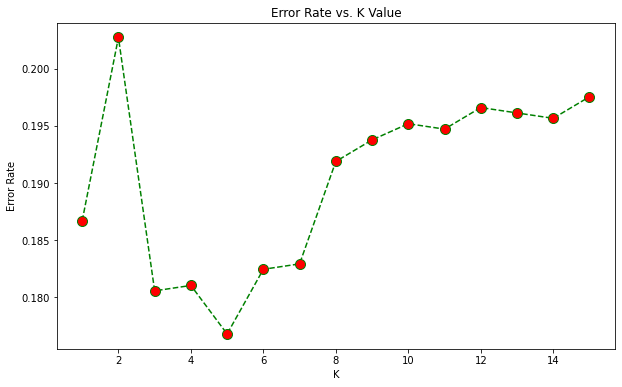

In [71]:
plt.figure(figsize=(10,6))
plt.plot(range(1,16),error_rate,color='green', linestyle='dashed',marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
req_k_value = error_rate.index(min(error_rate))+1
print("Minimum error:-",min(error_rate),"at K =",req_k_value)

In [72]:
k_range = list(range(1, 20))
param_grid = dict(n_neighbors=k_range)

In [73]:
CV_knn = grid = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', return_train_score=False,verbose=1)
CV_knn.fit(Xtrain, y_tr)

Fitting 3 folds for each of 19 candidates, totalling 57 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_neighbors=15),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy', verbose=1)

In [74]:
print(CV_knn.best_params_,CV_knn.best_score_)

{'n_neighbors': 3} 0.8075227263360554


In [75]:
df = pd.DataFrame(CV_knn.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003326,0.000444,0.040473,0.001866,1,{'n_neighbors': 1},0.808975,0.801092,0.800971,0.803679,0.003745,2
1,0.003199,0.000017,0.042954,0.001148,2,{'n_neighbors': 2},0.781686,0.781686,0.780340,0.781237,0.000635,16
2,0.003029,0.000023,0.043224,0.002032,3,{'n_neighbors': 3},0.808975,0.798666,0.814927,0.807523,0.006718,1
3,0.003054,0.000121,0.043863,0.004496,4,{'n_neighbors': 4},0.795027,0.785324,0.797330,0.792561,0.005202,5
4,0.003022,0.000206,0.047643,0.004365,5,{'n_neighbors': 5},0.793814,0.799272,0.806432,0.799840,0.005167,3
5,0.003829,0.001318,0.049041,0.007853,6,{'n_neighbors': 6},0.784112,0.796240,0.795510,0.791954,0.005553,6
6,0.003069,0.000153,0.044024,0.000479,7,{'n_neighbors': 7},0.782899,0.794421,0.808252,0.795191,0.010365,4
7,0.002986,0.000119,0.046779,0.003213,8,{'n_neighbors': 8},0.779260,0.791995,0.795510,0.788922,0.006981,8
8,0.003360,0.000114,0.047067,0.001475,9,{'n_neighbors': 9},0.774409,0.790176,0.797330,0.787305,0.009575,10
9,0.003090,0.000076,0.046536,0.001007,10,{'n_neighbors': 10},0.776834,0.793208,0.794903,0.788315,0.008147,9


In [76]:
df = pd.DataFrame(CV_knn.cv_results_)
mask = df['rank_test_score']<10
newdf = df[mask]
newdf[['param_n_neighbors','params','mean_test_score','rank_test_score']]

,param_n_neighbors,params,mean_test_score,rank_test_score
0,1,{'n_neighbors': 1},0.803679,2
2,3,{'n_neighbors': 3},0.807523,1
3,4,{'n_neighbors': 4},0.792561,5
4,5,{'n_neighbors': 5},0.799840,3
5,6,{'n_neighbors': 6},0.791954,6
6,7,{'n_neighbors': 7},0.795191,4
7,8,{'n_neighbors': 8},0.788922,8
9,10,{'n_neighbors': 10},0.788315,9
10,11,{'n_neighbors': 11},0.789125,7


In [77]:
#skfolds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)
skfolds = KFold(n_splits=3)

In [78]:
knn=KNeighborsClassifier(n_neighbors=5)
score = []
i = 0
for trainset,testset in skfolds.split(Xtrain,y_tr):
    predicted_targets = np.array([])
    actual_targets = np.array([])
    accuracy_list = list()
    predicted_train_targets = np.array([])
    actual_train_targets = np.array([])
    accuracy_train_list = list()
    print("folds ", i)
    print(trainset,"having :" , len(trainset))
    print(testset,"having :" , len(testset))

    x_tr,x_te=Xtrain[trainset],Xtrain[testset]
    y_trin,y_test=y_tr[trainset],y_tr[testset]

    #clone_clf = clone(svm)
    knn.fit(x_tr, y_trin)
    predicted_labels = knn.predict(x_te)
    accuracy = accuracy_score(y_test, predicted_labels)
    
    predicted_t_labels = knn.predict(x_tr)
    accuracy_t = accuracy_score(y_trin, predicted_t_labels)
    
    predicted_targets = np.append(predicted_targets, predicted_labels)
    actual_targets = np.append(actual_targets, y_test)
    accuracy_list.append(accuracy)
    
    predicted_train_targets = np.append(predicted_train_targets, predicted_t_labels)
    actual_train_targets = np.append(actual_train_targets, y_trin)
    accuracy_train_list.append(accuracy_t)
    
    print("iteration", i)
    i+=1

folds  0
[1649 1650 1651 ... 4943 4944 4945] having : 3297
[   0    1    2 ... 1646 1647 1648] having : 1649
iteration 0
folds  1
[   0    1    2 ... 4943 4944 4945] having : 3297
[1649 1650 1651 ... 3295 3296 3297] having : 1649
iteration 1
folds  2
[   0    1    2 ... 3295 3296 3297] having : 3298
[3298 3299 3300 ... 4943 4944 4945] having : 1648
iteration 2


In [79]:
labeles = ['CBD','CB_Healthy','CWD','Leaf Healthy','Cercospora','Mold','Phoma','CLR']

	Validation Accuracy of KNN: 0.8022


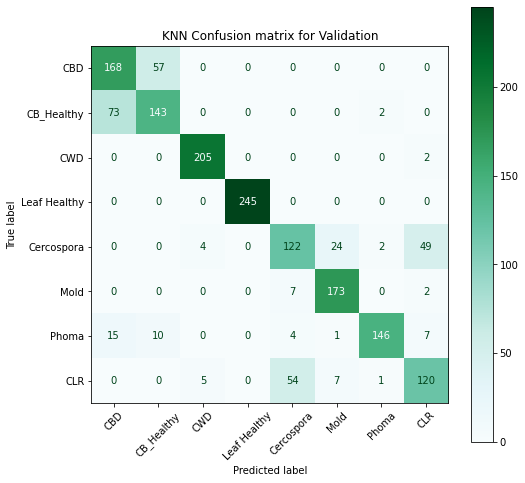

In [80]:
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predicted_labels, np.ravel(y_test, order='C'))
    print("\tValidation Accuracy of KNN: %0.4f" % acc)
    cm = confusion_matrix(actual_targets, predicted_targets, labels=knn.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("KNN Confusion matrix for Validation")
    plt.show()

	Training Accuracy of KNN: 0.8720


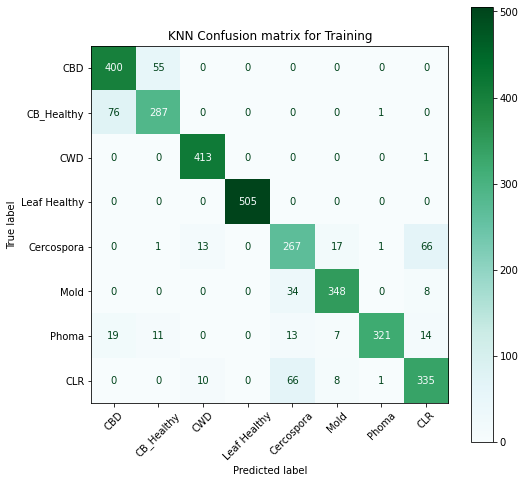

In [81]:
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predicted_t_labels, np.ravel(y_trin, order='C'))
    print("\tTraining Accuracy of KNN: %0.4f" % acc)
    cm = confusion_matrix(actual_train_targets, predicted_train_targets, labels=knn.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("KNN Confusion matrix for Training")
    plt.show()

In [82]:
result = knn.predict(Xtest)

acc = accuracy_score(result, np.ravel(y_te, order='C'))
print("\tTesting Accuracy of KNN: %0.4f" % acc)
print(classification_report(y_te,result))

	Testing Accuracy of KNN: 0.8095
              precision    recall  f1-score   support

           0       0.68      0.73      0.71       292
           1       0.64      0.68      0.66       250
           2       0.95      0.98      0.97       266
           3       1.00      1.00      1.00       321
           4       0.63      0.66      0.65       243
           5       0.90      0.91      0.90       246
           6       0.98      0.79      0.87       243
           7       0.69      0.68      0.69       260

    accuracy                           0.81      2121
   macro avg       0.81      0.80      0.81      2121
weighted avg       0.82      0.81      0.81      2121



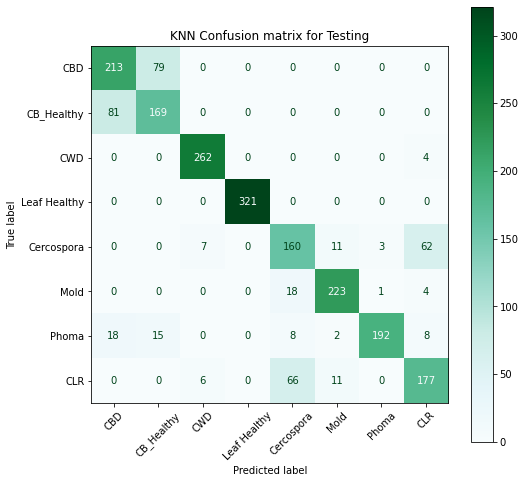

In [83]:
    fig,ax = plt.subplots(figsize=(8,8))
    cm = confusion_matrix(y_te, result, labels=knn.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("KNN Confusion matrix for Testing")
    plt.show()

In [ ]:
from yellowbrick.classifier import ROCAUC,ConfusionMatrix

In [84]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0:'cbd',1: 'cb_healthy',2: 'CWD', 3 :'leaf healthy' ,4: 'Cercospora', 5: 'mold', 6: 'phoma',7 : 'rust'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

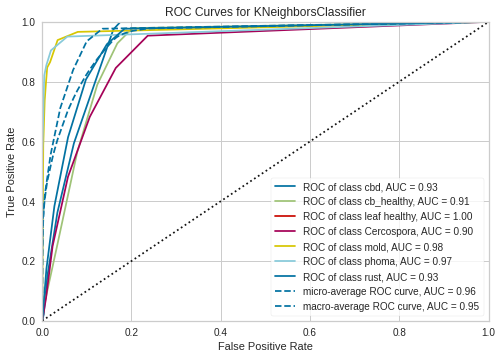

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f74a2394490>,
       encoder={0: 'cbd', 1: 'cb_healthy', 2: 'leaf healthy', 3: 'Cercospora',
                4: 'mold', 5: 'phoma', 6: 'rust'},
       estimator=KNeighborsClassifier(n_neighbors=7))

In [ ]:
plot_ROC_curve(knn,Xtrain,y_tr,Xtest,y_te)